In this notebook, we will look at one of the decarboxylative coupling datasets published by MacMillan and co-workers in Science 2022, 376 (6592), 532-539. In this dataset, three aryl bromides from the informer library are coupled with many carboxylic acids.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import colorsys
from scipy.stats import ks_2samp

# Doyle colors
doyle_colors = ["#CE4C6F", "#1561C2", "#188F9D","#C4ADA2","#515798", "#CB7D85", "#A9A9A9"]
# extension of palette with lighter and darker versions
def adjust_lightness(color, factor=1.2):
    """
    Function to make colors lighter (factor > 1) or darker (factor < 1).
    """
    r, g, b = mcolors.to_rgb(color)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    l = max(0, min(1, l * factor))
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return mcolors.to_hex((r, g, b))

lighter = [adjust_lightness(c, 1.2) for c in doyle_colors]
darker  = [adjust_lightness(c, 0.7) for c in doyle_colors]
all_colors = doyle_colors + darker[::-1] + lighter[::-1] 

# Save the categorical colormap
cat_cmap = ListedColormap(all_colors, name="Doyle_cat")
plt.colormaps.register(cat_cmap)

# Define and save a continuous colormap
colors = [doyle_colors[1],"#FFFFFFD1",doyle_colors[0]]
cont_cmap = LinearSegmentedColormap.from_list("Doyle_cont", colors)
plt.colormaps.register(cont_cmap)

# General plt parameters
plt.rcParams.update({
    "axes.titlesize": 20,        # Subplot title
    "axes.labelsize": 16,        # X and Y labels
    "figure.titlesize": 24,      # Suptitle
    "xtick.labelsize": 14,       # X tick labels
    "ytick.labelsize": 14,       # Y tick labels
    "legend.fontsize": 14,       # Legend text
    "legend.title_fontsize": 14  # Legend titles
})

### Dataset processing

In [2]:
data = pd.read_csv("xec_raw_dset_full.csv",index_col=0, header=0)
data.head(3)

,Plate,Rxn_Plate_Row,Rxn_Plate_Col,Prod_Smiles,Rxn_Plate,Product_theoretical_umol,Target Mass,ArX_ID,ArX_Smiles,ArX_umol,...,Solution_Photocatalyst_solute,Solution_Ligand_ID,Solution_Ligand_Smiles,Solution_Ligand_umol,Solution_Ligand_equiv_rel_to_solute,Solution_Ligand_conc,Solution_Ligand_solute,CAD Yield,UV210_Prod AreaAbs,UV254_Prod AreaAbs
Reaction #,,,,,,,,,,,,,,,,,,,,,
1,1,1,1,COC(=O)CC1CCc2cc(cc3c2n1c(=O)c(=O)[nH]3)C4CC4,20hr_25C,0.1,314.13,MFCD00920757,COC(=O)CC1CCc2cc(cc3c2n1c(=O)c(=O)[nH]3)Br,0.1,...,Catalyst,MFCD01863731,CC(C)(C)c1ccnc(c1)c2cc(ccn2)C(C)(C)C,0.015,1.5,Neat,Catalyst,1.5,0.0,0.0
2,1,1,2,COC(=O)CC1CCc2cc(cc3c2n1c(=O)c(=O)[nH]3)C4(CC4...,20hr_25C,0.1,424.12,MFCD00920757,COC(=O)CC1CCc2cc(cc3c2n1c(=O)c(=O)[nH]3)Br,0.1,...,Catalyst,MFCD01863731,CC(C)(C)c1ccnc(c1)c2cc(ccn2)C(C)(C)C,0.015,1.5,Neat,Catalyst,0.0,13409.8,1748.5
3,1,1,3,COC(=O)CC1CCc2cc(cc3c2n1c(=O)c(=O)[nH]3)C4(CCC...,20hr_25C,0.1,438.13,MFCD00920757,COC(=O)CC1CCc2cc(cc3c2n1c(=O)c(=O)[nH]3)Br,0.1,...,Catalyst,MFCD01863731,CC(C)(C)c1ccnc(c1)c2cc(ccn2)C(C)(C)C,0.015,1.5,Neat,Catalyst,6.0,147554.5,23453.8


The experimental data is divided into reaction carried out in the presence and absence of phthalimide as a reaction additive. We were interested in the reaction carried out with the additive.

In [3]:
# remove reactions without additive
data = data.loc[data["Additive_equiv"] != 0]
print("Remaining options for the additive equivalaents after filtering:", 
      list(data["Additive_equiv"].unique()))
print("NUmber of reactions in the dataset:", len(data))

Remaining options for the additive equivalaents after filtering: [1]
NUmber of reactions in the dataset: 1536


The full experimental dataset contains two sub-datasets:
* 1 complex acid coupled with many aryl bromides (see other notebook for this dataset)
* 3 complex aryl bromides coupled with many acids (dataset of interest here)

As the complex acid is not in the dataset with the complex bromides, we can restrict to the aryl bromides dataset by removing reactions with the complex acids.

In [4]:
# remove runs containing the complex acid (which is not present in the reactions of the complex bromides)
data = data.loc[data["Acid_Smiles"] != "Cn1c2c(c(n1)C(=O)N3CCC(CC3)C(=O)O)CN(CC2)C(=O)C4CC4"]
# The remaining reactions should be 3*384 = 1152
print(f"After reactions of the complex acid are removed, there are {len(data)} reactions left in the dataset.")

# limit to columns that are required here and remove the rest
keep_col = ["Prod_Smiles","ArX_Smiles","Acid_Smiles","CAD Yield"]
data = data[keep_col]
# Ensure that the smiles are canonical
for col in keep_col[:3]:  # skip yield column
    data[col] = data[col].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), canonical = True))

After reactions of the complex acid are removed, there are 1152 reactions left in the dataset.


In [ ]:
# save the substrate smiles
pd.DataFrame(list(data["ArX_Smiles"].unique()) + 
             list(data["Acid_Smiles"].unique())).to_csv("./Datasets/0_Descriptor_Calculation/"\
                                                        "xec_smiles_acid_scope_subs.csv",index=False)

In [6]:
print("Number of acid substrates before filtering: ", len(data["Acid_Smiles"].unique()))

Number of acid substrates before filtering:  384


Get some insights into the yield distribution

Dataset without filtering samples:

Number of samples: 1152
Ratio of samples below 10% yield: 53.1%
Ratio of samples below 1% yield: 28.0%
Average yield: 18.4%


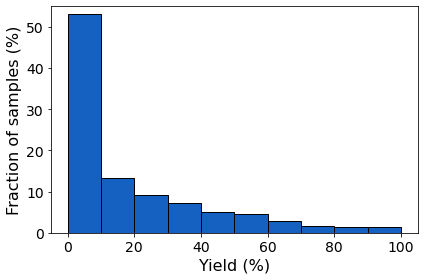

In [7]:
print("Dataset without filtering samples:\n")
print(f"Number of samples: {len(data)}")
for cutoff_yield in [10, 1]:
    print(f"Ratio of samples below {cutoff_yield}% yield:"\
          f" {round(len(data.loc[data['CAD Yield'] < cutoff_yield])/len(data)*100, 1)}%")
print(f"Average yield: {round(data['CAD Yield'].mean(), 1)}%")

plt.figure(figsize=(6, 4))
plt.hist(data["CAD Yield"], bins=10, range=(0, 100), 
         weights=[100/len(data["CAD Yield"])]*len(data["CAD Yield"]),
         edgecolor="k", color=all_colors[1])
plt.tick_params(axis='both', which='major')
plt.xlabel("Yield (%)")
plt.ylabel("Fraction of samples (%)")
plt.ylim(0,55)
plt.tight_layout()
plt.show()

The dataset has a very low performance with more than half of the samples giving less than 10% yield. Due to this low performance, we decided to prune the dataset by removing acids that perform poorly for all three aryl bromides.

Filtering acids that give 0% product for all aryl bromides:

Number of cut acids: 42
Number of reactions after filtering: 1026
Ratio of samples below 10% yield: 47.4%
Ratio of samples below 1% yield: 19.1%
Average yield: 20.7%


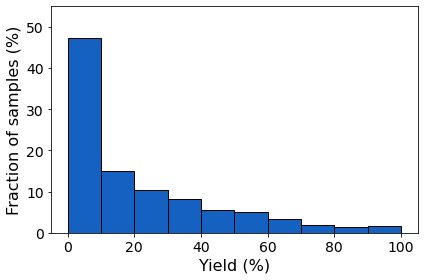

In [8]:
def dset_pruning(data,cut):
    if cut == 0:
        print(f"Filtering acids that give 0% product for all aryl bromides:\n")
    else:
        print(f"Filtering acids that give ≤{cut}% product for all aryl bromides:\n")
    zeros = data.loc[data["CAD Yield"] <= cut]
    counts = zeros["Acid_Smiles"].value_counts()
    values_always_0 = counts[counts == 3].index
    print(f"Number of cut acids: {len(values_always_0)}")
    data_filtered = data.copy(deep=True)
    for idx in data_filtered.index:
        if data_filtered.loc[idx,"Acid_Smiles"] in values_always_0:
            data_filtered.drop(index=idx,inplace=True)
    print(f"Number of reactions after filtering: {len(data_filtered)}")
    for cutoff_yield in [10, 1]:
        print(f"Ratio of samples below {cutoff_yield}% yield:"\
            f" {round(len(data_filtered.loc[data_filtered['CAD Yield'] < cutoff_yield])/len(data_filtered)*100, 1)}%")
    print(f"Average yield: {round(data_filtered['CAD Yield'].mean(),1)}%")
    plt.figure(figsize=(6, 4))
    plt.hist(data_filtered["CAD Yield"], bins=10, range=(0, 100), 
            weights=[100/len(data_filtered["CAD Yield"])]*len(data_filtered["CAD Yield"]),
            edgecolor="k", color=all_colors[1])
    plt.tick_params(axis='both', which='major')
    plt.xlabel("Yield (%)")
    plt.ylabel("Fraction of samples (%)")
    plt.ylim(0,55)
    plt.tight_layout()
    plt.show()

    return data_filtered

_ = dset_pruning(data,0)

The distribution is slightly better, but the overall performance is still very poor. Let's try to prune a little bit more.

Filtering acids that give ≤5% product for all aryl bromides:

Number of cut acids: 89
Number of reactions after filtering: 885
Ratio of samples below 10% yield: 39.0%
Ratio of samples below 1% yield: 9.3%
Average yield: 23.9%


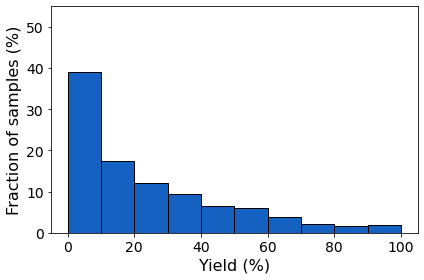

In [9]:
data_filtered = dset_pruning(data,5)

Pruning acids that give 5% or less for all three aryl bromides, improves the performance to a more suitable level. We decided to move forward with this filtered dataset.

To evaluate whether the dataset has the same distribution as the optimization dataset ArI-DS-low, which appears visually similar, we carried out a Kolmogorov-Smirnov test.

In [13]:
def normalize(data):
    min_val = data.min()
    max_val = data.max()
    return data.apply(lambda x: (x- min_val) / (max_val - min_val))

print("Kolmogorov-Smirnov analysis for the decarboxylation acid dataset compared to the low-performing ArI dataset ArI-DS-low:\n")
df_ari = pd.read_csv(f"./../../dataset_ArI/0_Data/Datasets/Datasets_Hyperpar_Opt/data-low.csv",index_col=0)

statistic, p_value = ks_2samp(normalize(df_ari["rate"]), normalize(data_filtered["CAD Yield"]))

print("KS statistic:", statistic)
print("p value:", p_value)
print("")
print("Note: The data was normalized to only compare the distribution shape.")


Kolmogorov-Smirnov analysis for the decarboxylation acid dataset compared to the low-performing ArI dataset ArI-DS-low:

KS statistic: 0.12150849655960781
p value: 1.3912717263037327e-06

Note: The data was normalized to only compare the distribution shape.


The p value is below 0.05, and the null hypothesis was therefore rejected, indicating the distributions are not the same shape.

In [10]:
# Save the dataset
data_filtered.to_csv("xec_raw_dset_acid_scope.csv",index=True,header=True)
data_filtered.head(3)

,Prod_Smiles,ArX_Smiles,Acid_Smiles,CAD Yield
Reaction #,,,,
385,COC(=O)CC1CCc2cc(C3CC3)cc3[nH]c(=O)c(=O)n1c23,COC(=O)CC1CCc2cc(Br)cc3[nH]c(=O)c(=O)n1c23,O=C(O)C1CC1,10.0
386,COC(=O)CC1CCc2cc(C3(c4ccc(Cl)cc4)CC3)cc3[nH]c(...,COC(=O)CC1CCc2cc(Br)cc3[nH]c(=O)c(=O)n1c23,O=C(O)C1(c2ccc(Cl)cc2)CC1,1.4
388,COC(=O)CC1CCc2cc(C[C@@H]3C[C@H](C(C)=O)C3(C)C)...,COC(=O)CC1CCc2cc(Br)cc3[nH]c(=O)c(=O)n1c23,CC(=O)[C@H]1C[C@@H](CC(=O)O)C1(C)C,0.0


Taking a look at the structures in the dataset:

There are 3 aryl bromides in the dataset.


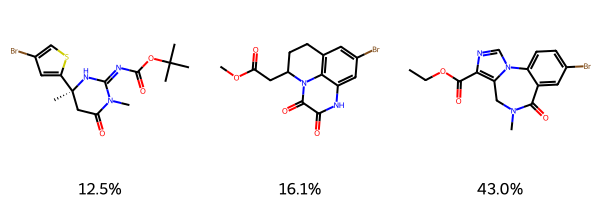

In [11]:
# Get the different aryl bromides
bromide_smiles = list(data["ArX_Smiles"].unique())
# Ensure that there are not duplicates
bromide_smiles = list(set(bromide_smiles))
print(f"There are {len(bromide_smiles)} aryl bromides in the dataset.")

bromide_mols = [Chem.MolFromSmiles(bromide) for bromide in bromide_smiles]
yields = []
for bromide in bromide_smiles:
    yields.append(data_filtered[data_filtered["ArX_Smiles"] == bromide]["CAD Yield"].mean())
yields = [f"{val:.1f}%" for val in yields]
Draw.MolsToGridImage(bromide_mols, molsPerRow=3,subImgSize=(200,200),legends = yields)

There are 295 acides in the dataset.


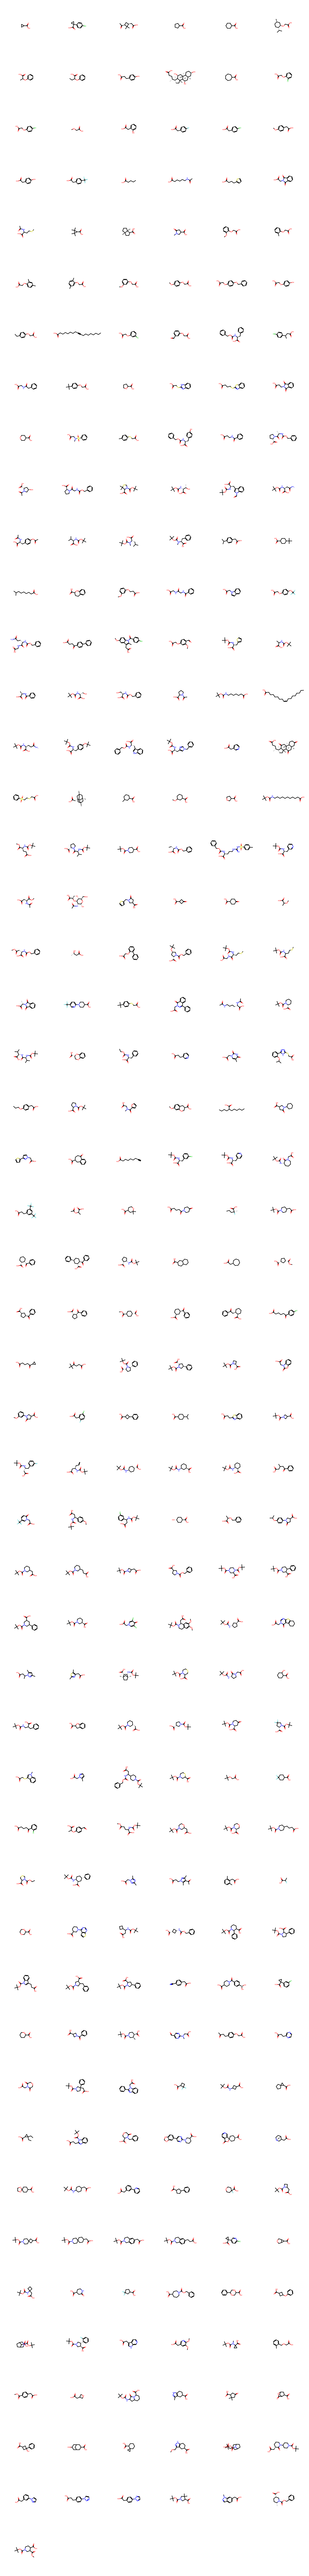

In [12]:
# record the acids that remain in the dataset
acid_smiles = list(data_filtered["Acid_Smiles"].unique())
print(f"There are {len(acid_smiles)} acides in the dataset.")
Draw.MolsToGridImage([Chem.MolFromSmiles(acid) for acid in acid_smiles],molsPerRow= 6,maxMols=10000,subImgSize=(200,200))

In [ ]:
# save the product smiles
pd.DataFrame(list(data_filtered["Prod_Smiles"].unique())).to_csv("./Datasets/0_Descriptor_Calculation/"\
                                                        "xec_smiles_acid_scope_prod.csv")